1. [Ingest Quandl bundle in Zipline](#Ingest-Quandl-bundle-in-Quantopian-Zipline)

1. [Load data bundle](#Load-data-bundle)

1. [Time Series Analysis](#Time-Series-Analysis)
    
1. [Introduction to Trading Strategies](#Introduction-to-Trading-Strategies)    
   

# Ingest Quandl bundle in Zipline
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

Zipline has included a bundle from Quandl (financial data provider) with US stocks from 1990. To be able to use free Quandl data, you need to sign up for an account and get an API key to download the data. On the command line you should run: <br>
```javascript
QUANDL_API_KEY=your_quandl_api_key zipline ingest -b quandl
```

and then type:

In [4]:
!zipline bundles

csvdir <no ingestions>
ibex35_stock_data 2020-08-07 16:40:30.271346
quandl 2020-08-11 11:21:20.009622
quantopian-quandl <no ingestions>


The quandl bundle has been ingested with success. <br>
Let's now proceed with importing the necessary libraries.

In [4]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import zipline
from yahoofinancials import YahooFinancials
import warnings


# Default working directory
# os.chdir("../data")

# Display maximum columns
pd.set_option('display.max_columns', None)

# Seaborn graphic style as default
plt.style.use('seaborn')
# Graphics default size
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200

# Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Load IPython Magic
%load_ext watermark
%load_ext zipline

In [5]:
%watermark --iversions

zipline 1.4.0
pandas  0.22.0
numpy   1.14.2



# Load data bundle
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

Next, we will proceed with loading our bundle. For such purpose, the [video](https://subscription.packtpub.com/video/application_development/9781789951165) <i>Machine Learning for Algorithmic Trading Bots in Python</i> by Mustafa Qamar-ud-Din, has been of great help. <br>
As usual, let's first import necessary libraries plus additional load extensions in the IPython magic. Check this [GitHub thread](https://github.com/quantopian/zipline/issues/1542) for more information.<br>
On how to proceed with this section, this other [GitHub thread](https://github.com/quantopian/zipline/issues/1579) might also be worth exploring.

In [3]:
from zipline.data.data_portal import DataPortal
from zipline.data import bundles
from zipline.utils.calendars import get_calendar

import os

from zipline.utils.run_algo import load_extensions

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

First, as abovementioned, we load our quandl bundle.

In [4]:
bundle_data = bundles.load('quandl')

In [5]:
print(type(bundle_data))

<class 'zipline.data.bundles.core.BundleData'>


Second, we initialise our DataPortal interface with the below mandatory arguments.
We shall beforehand define our end_date argument and check for the first trading day.

In [6]:
end_date = pd.Timestamp("2018-03-27", tz="utc")

In [7]:
bundle_data.equity_daily_bar_reader.first_trading_day

Timestamp('1990-01-02 00:00:00+0000', tz='UTC')

In [8]:
data_por = DataPortal(
    asset_finder=bundle_data.asset_finder,
    trading_calendar=get_calendar("NYSE"),
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_daily_reader=bundle_data.equity_daily_bar_reader
)

Third, we will build our DataFrame for further analysis and feature preprocessing. For such purpose, we shall use a get_history_window method on the data portal interface.

In [9]:
AAPL = data_por.asset_finder.lookup_symbol(
    'AAPL',
    as_of_date=None
)

In [10]:
df = data_por.get_history_window(
    assets=[AAPL],
    end_dt=end_date,
    bar_count=7000,
    frequency='1d',
    data_frequency='daily',
    field='open'
)

In [12]:
df.tail()

,Equity(8 [AAPL])
2018-03-21 00:00:00+00:00,175.04
2018-03-22 00:00:00+00:00,170.00
2018-03-23 00:00:00+00:00,168.39
2018-03-26 00:00:00+00:00,168.07
2018-03-27 00:00:00+00:00,173.68


We now index our date column and rename the stock column after the ticker's name.

In [13]:
df.index = pd.DatetimeIndex(df.index)

The name of the column <i>Equity(0 [AAPL])</i> is a Pandas object (more concretely, a 'zipline.assets._assets.Equity' object). When we attempt to rename it, a TypeError is displayed (Index does not support mutable operations). As such, we will create another identical column thus passing a list method to the column name and then dropping the original column.

In [14]:
df['close'] = df[list(df.columns)[0]]

In [15]:
df = df.drop(columns=[list(df.columns)[0]])
df.head()

,close
1990-06-15 00:00:00+00:00,39.75
1990-06-18 00:00:00+00:00,39.25
1990-06-19 00:00:00+00:00,39.00
1990-06-20 00:00:00+00:00,39.88
1990-06-21 00:00:00+00:00,40.00


# Time Series Analysis
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

In this section, we will delve into the series statistical properties and perform visualisations, some of which have been excerpted in this book [Python for Finance Cookbook](#"https://www.packtpub.com/product/python-for-finance-cookbook/9781789618518"), by Eryk Lewinson.

In [15]:
df.describe()

,REP
count,5226.000000
mean,17.577431
std,4.391224
min,6.030000
25%,14.410000
50%,17.137500
75%,20.500000
max,30.350000


## Converting prices to returns

As we shall see in the visualisation, asset returns are non-stationnary, neither in mean nor in variance. We may attempt to make them stationnary by converting prices to returns, both simple returns (aggregating to assets) and log-returns (aggregating over time). <br>

Stationarity is an important statistical property meaning that the statistical properties of a stochastic process do not change over time, that is shift invariance (in time) of the finite dimensional distributions of a stochastic process or shift-invariance (in time) of the first moment and the cross moment (the auto-covariance).

In [16]:
df['simple_rtn'] = df.close.pct_change()
df['log_rtn'] = np.log(df.close/df.close.shift(1))

In [28]:
df.head()

,close,simple_rtn,log_rtn
1990-06-18 00:00:00+00:00,39.25,-0.012579,-0.012658
1990-06-19 00:00:00+00:00,39.00,-0.006369,-0.006390
1990-06-20 00:00:00+00:00,39.88,0.022564,0.022313
1990-06-21 00:00:00+00:00,40.00,0.003009,0.003005
1990-06-22 00:00:00+00:00,42.00,0.050000,0.048790


In [18]:
df = df.dropna() # We drop NAs

## Time Series visualisations

[Text(0, 0.5, 'Log returns (%)'), Text(0.5, 0, 'date')]

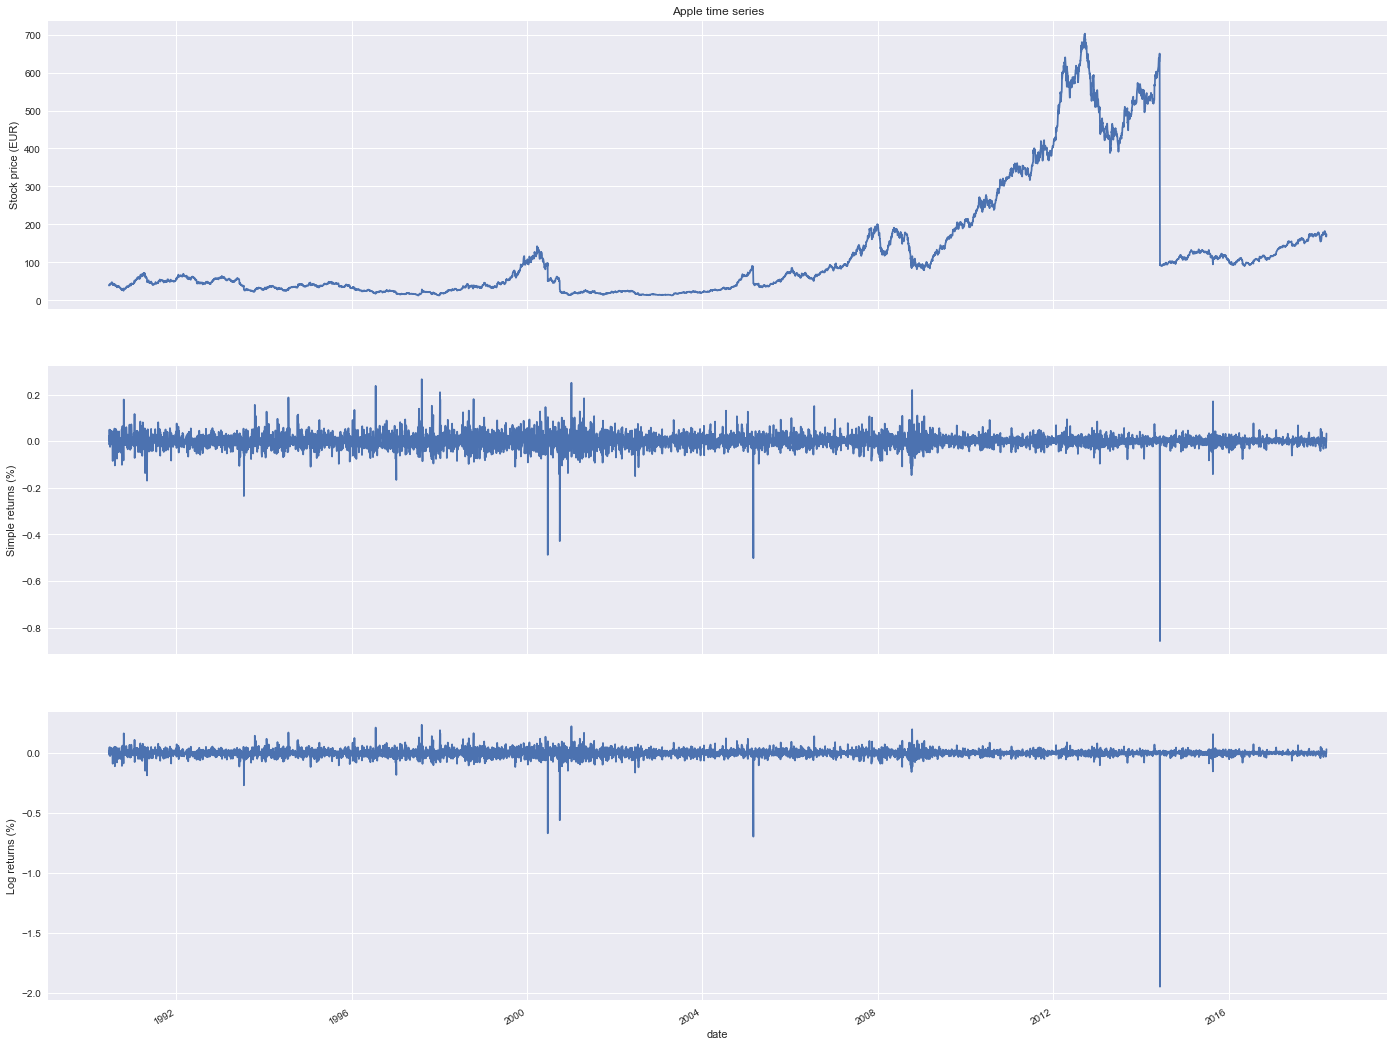

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(24, 20), sharex=True)

df.close.plot(ax=ax[0])
ax[0].set(title = 'Apple time series',
          ylabel = 'Stock price (EUR)')
    
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')

df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'date', 
          ylabel = 'Log returns (%)')

## Stylized facts of asset returns

In [23]:
# Import necessary libraries
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

**1.- Non Gaussian distribution of returns**

In [24]:
# Calculate the normal Probability Density Function (PDF)
r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean()
sigma = df.log_rtn.std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma) 

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Q-Q plot')

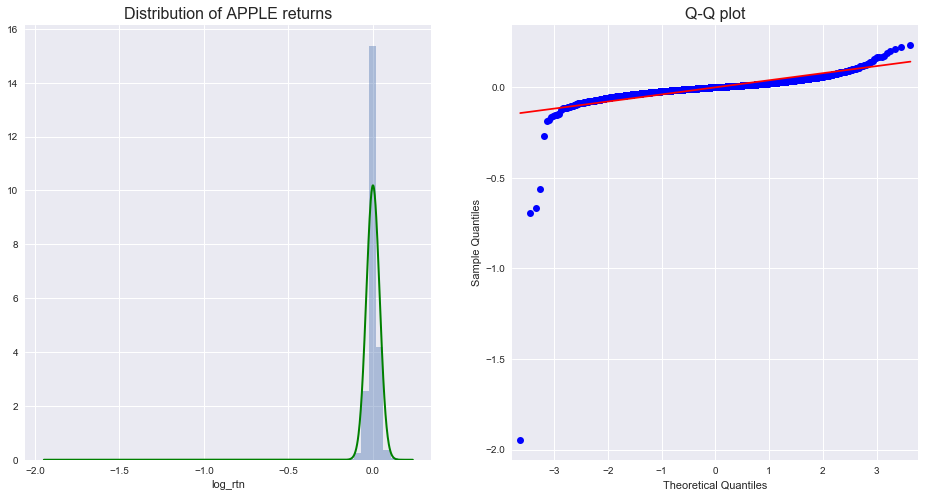

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0]) 
ax[0].set_title('Distribution of APPLE returns', fontsize=16) 
ax[0].plot(r_range, norm_pdf, 'g', lw=2)
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)

In [26]:
# Print the summary statistics of the log returns

jb_test = scs.jarque_bera(df.log_rtn.values)

print('---------- Descriptive Statistics ----------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print('Mean: {:.4f}'.format(df.log_rtn.mean()))
print('Median: {:.4f}'.format(df.log_rtn.median()))
print('Min: {:.4f}'.format(df.log_rtn.min()))
print('Max: {:.4f}'.format(df.log_rtn.max()))
print('Standard Deviation: {:.4f}'.format(df.log_rtn.std()))
print('Skewness: {:.4f}'.format(df.log_rtn.skew()))
print('Kurtosis: {:.4f}'.format(df.log_rtn.kurtosis())) 
print('Jarque-Bera statistic: {:.2f} with p-value: {:.2f}'.format(jb_test[0], jb_test[1]))

---------- Descriptive Statistics ----------
Range of dates: 1990-06-18 - 2018-03-27
Number of observations: 6995
Mean: 0.0002
Median: 0.0003
Min: -1.9475
Max: 0.2361
Standard Deviation: 0.0392
Skewness: -19.4133
Kurtosis: 908.2773
Jarque-Bera statistic: 240538900.68 with p-value: 0.00


The log-returns series doest not match a normal gaussian distribution but more of a t-distribution, that is values centered around the mean and fat tails, meaning the presence of outliers (which can also be seen in the Q-Q plot). Actually, the distribution is leptokurtic (excess kurtosis of 3) implying the aforementioned profusion of outliers. The distribution is shows a negative skewness (positive log-returns greater than negative ones). <br>

These characteristics are typical for financial series.

**2.- Volatility Clustering**

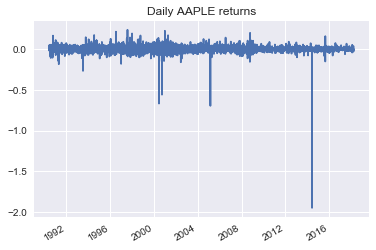

In [29]:
df.log_rtn.plot(title='Daily AAPLE returns')

We see that there are volatility clusters along the time axis.

**3.-Autocorrelation**

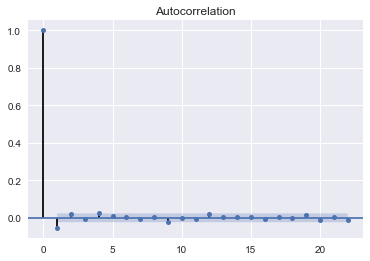

In [30]:
acf = smt.graphics.plot_acf(df.log_rtn, 
                      lags=22, # A month
                      alpha=0.05)

We can assume this test is statistically significant for few values lie outside the confidence intervals. We can conclude there is no autocorrelation in log-returns lags. Let's test ACF in squared and absolute log-returns values.

[Text(0, 0.5, 'Absolute Returns'), Text(0.5, 0, 'Lag')]

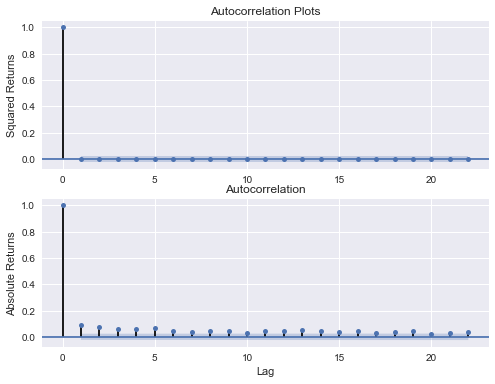

In [31]:
# ACF in squared and absolute log-returns
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

smt.graphics.plot_acf(df.log_rtn ** 2, lags=22, 
                      alpha=0.05, ax = ax[0])

ax[0].set(title='Autocorrelation Plots',
          ylabel='Squared Returns')

smt.graphics.plot_acf(np.abs(df.log_rtn), lags=22, 
                      alpha=0.05, ax = ax[1])
ax[1].set(ylabel='Absolute Returns',
          xlabel='Lag')

There is a discrete decaying autocorrelation in squared and absolute log-returns. We will in principle include new lagged variables in our DataFrame that may influence our regressor.

# Introduction to Trading Strategies
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

**Initial Considerations**<br>
Before we pass on our first trading algorithm, we need to fix two issues on our Zipline version 1.4:
<ol>
    <li>start time/end time are now pd.Timestamp data types</li>
    <li>the zipline library must be explicitly told not to perform benchmarking</li>
</ol>

For more information, check this link to [Quantopian thread](https://www.quantopian.com/posts/new-book-on-quantopian-slash-zipline-backtesting-and-modeling).<br>

**Trading Strategies**<br>
We shall build two strategies: <br>
<ol>
    <li>Technical Analysis strategy based on Dual Moving Average</li>
    <li>Buy and Hold strategy based on trained ML model</li>
</ol>

with the purpose of checking to what extent can ML improve traditional trading and financial analysis. <br>

More on the following notebooks